## **RNL - Modelo Massa-Mola** 


## **Step 1: Imports**

In [1]:
from jax.experimental.ode import odeint
from jax.experimental import optimizers
from jax.experimental import stax
from jax.lib import xla_bridge
import jax.numpy as jnp
import jax

# Verificando se a GPU está sendo usada
print(xla_bridge.get_backend().platform)

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


gpu


In [2]:
from functools import partial # reduces arguments to function by making some subset implicit
import pandas as pd
import numpy as np
import io

# visualization
import matplotlib.pyplot as plt

## **Step 2: Massa-Mola-Amortecedor**
The Lagrangian of this system is 

$$
\begin{align}
L = T - U
\end{align}
$$
$$
\begin{align}
L = \frac{1}{2}m \dot{x}^2 - (\frac{1}{2} k (x_o + x)^2 - m g x - \frac{1}{2} k x_o^2)
\end{align}
$$

$$
\begin{align}
x_o = \frac{m g}{k}
\end{align}
$$
$$
\begin{align}
m = 150 g = 0,15 kg
\end{align}
$$
$$
\begin{align}
k = 162
\end{align}
$$
$$
\begin{align}
g = 9.8  m/s^2
\end{align}
$$


<img src="https://www.researchgate.net/publication/321688991/figure/fig1/AS:569465399189504@1512782539716/Figura-1-Sistema-massa-mola-vertical-em-equilibrio.png">

In [3]:
def calculate_xo(m, k, g):
  xo = (m * g) / k

  return xo

In [4]:
def lagrangian(q, q_dot, m=0.15, k=162, g=9.8):
  x, = q  
  v, = q_dot
  xo = calculate_xo(m=m, k=k, g=g)
  
  # kinetic energy (T)
  T = 0.5 * m * (v) ** 2

  # potential energy (V)
  V = + 0.5 * k * (xo + x) ** 2 - m * g * x - 0.5 * k * xo ** 2
 
  return T - V

The analytical of this system is 

\begin{align}
a = \frac{-k(x_0 + x)}{m} + g
\end{align}

<img src="https://www.researchgate.net/publication/321688991/figure/fig1/AS:569465399189504@1512782539716/Figura-1-Sistema-massa-mola-vertical-em-equilibrio.png">

In [5]:
def f_analytical(state, t=0, m=0.15, k=162, g=9.8):
  x, v = state
  xo = calculate_xo(m=m, k=k, g=g)

  a = (-k * (xo + x))/m + g

  return jnp.stack([v, a])

## **Step 3: Obtain dynamics from the Lagrangian**
To obtain the dynamics through numerical integration, and to do this we'll need an expression for $\ddot q$. Let's begin with the E-L constraint and try to solve for $\ddot q$.

$$
\begin{align}
\frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot q_j} - \frac{\partial \mathcal{L}}{\partial q_j} & = 0 & \text{write down the Euler-Lagrange equation} \quad (1)\\
\frac{d}{dt} \nabla_{\dot q} \mathcal{L} - \nabla_{q} \mathcal{L} & = 0 & \text{switch to vector notation} \quad (2)\\
(\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})\ddot q + (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L}) \dot q - \nabla_q \mathcal{L} & = 0 & \text{expand the time derivative }\frac{d}{dt} \quad (3)\\
\ddot q &= (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q] & \text{use a matrix inverse to solve for } \ddot q \quad (4)\\
\end{align}
$$

**Implementation.** If you look closely at Equation 4, you may notice that it involves both the Hessian and the gradient of a neural network during the forward pass of the LNN. This is not a trivial operation, but modern automatic differentiation makes things surprisingly smooth. Written in JAX, Equation 4 is just a few lines of code
```
q_tt = jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t)) @ (
    jax.grad(lagrangian, 0)(q, q_t)
    - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t)
```

In [6]:
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)

  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t)) @ (
  jax.grad(lagrangian, 0)(q, q_t)
  - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  
  return jnp.concatenate([q_t, q_tt])


def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)


@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m=0.15, k=162, g=9.8):
  L = partial(lagrangian, m=m, k=k, g=g)
  solved = solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)
  return solved


@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  solved = odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)
  return solved


def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:1] + np.pi) % (2 * np.pi) - np.pi, state[1:]])


def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [7]:
# choose an initial state
N = 10000
t = np.arange(start=0, stop=5, step=50/N, dtype=np.float32)
x0 = np.array([0.012, 0], dtype=np.float32)

In [8]:
# compute dynamics analytically
%time x_analytical = jax.device_get(solve_analytical(x0, t))

CPU times: user 591 ms, sys: 37.7 ms, total: 629 ms
Wall time: 1.02 s


In [9]:
# compute dynamics via autograd / the rewritten E-L equation
%time x_autograd = jax.device_get(solve_autograd(x0, t))

CPU times: user 1.09 s, sys: 29.4 ms, total: 1.12 s
Wall time: 1.17 s


### Plot a comparison

(-0.1, 5.0)

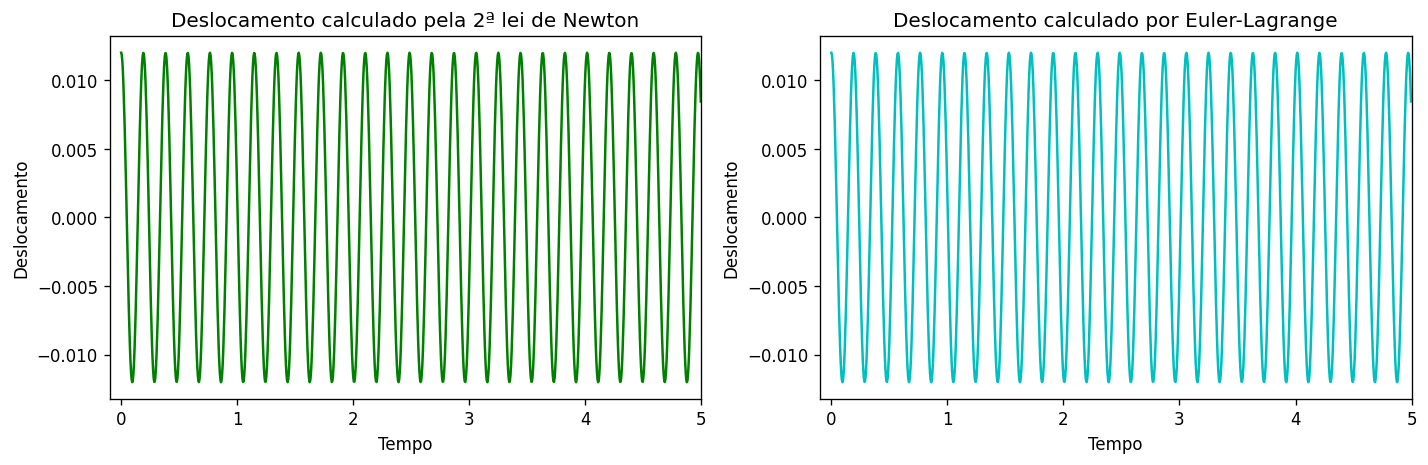

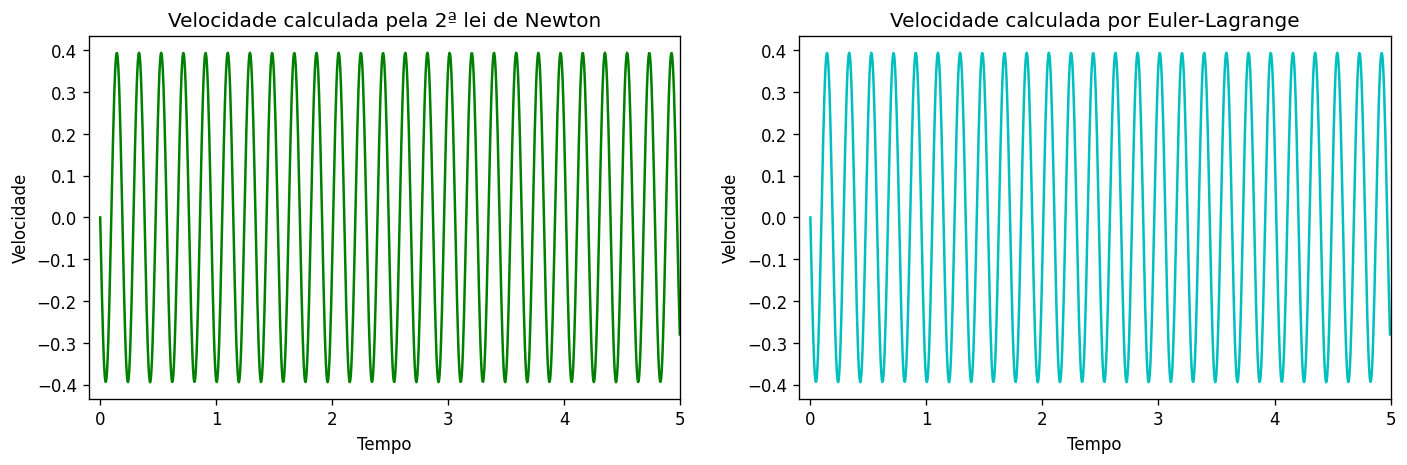

In [10]:
plt.figure(figsize=[14,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Deslocamento calculado pela 2ª lei de Newton")
plt.xlabel("Tempo") ; plt.ylabel("Deslocamento")
plt.plot(t, x_analytical[:, 0], 'g-', label=r'deslocamento') ; plt.xlim(-0.1, 5)
plt.subplot(1,2,2)
plt.title("Deslocamento calculado por Euler-Lagrange")
plt.xlabel("Tempo") ; plt.ylabel("Deslocamento")
plt.plot(t, x_autograd[:, 0], 'c-', label=r'deslocamento') ; plt.xlim(-0.1, 5)


plt.figure(figsize=[14,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Velocidade calculada pela 2ª lei de Newton")
plt.xlabel("Tempo") ; plt.ylabel("Velocidade")
plt.plot(t, x_analytical[:, 1], 'g-', label=r'velocidade') ; plt.xlim(-0.1, 5)
plt.subplot(1,2,2)
plt.title("Velocidade calculada por Euler-Lagrange")
plt.xlabel("Tempo") ; plt.ylabel("Velocidade")
plt.plot(t, x_autograd[:, 1], 'c-', label=r'velocidade') ; plt.xlim(-0.1, 5)

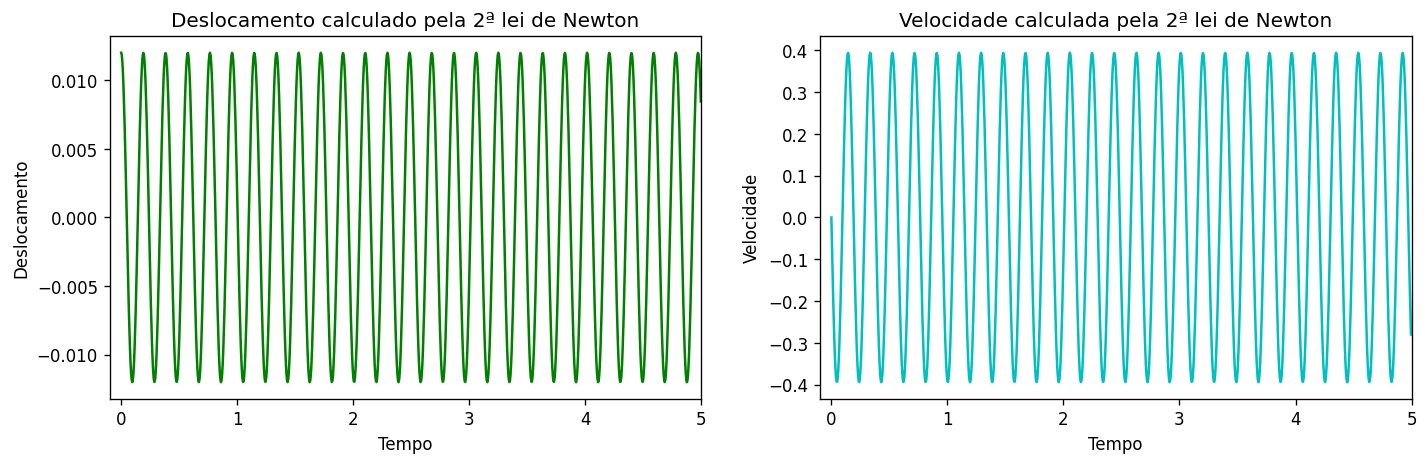

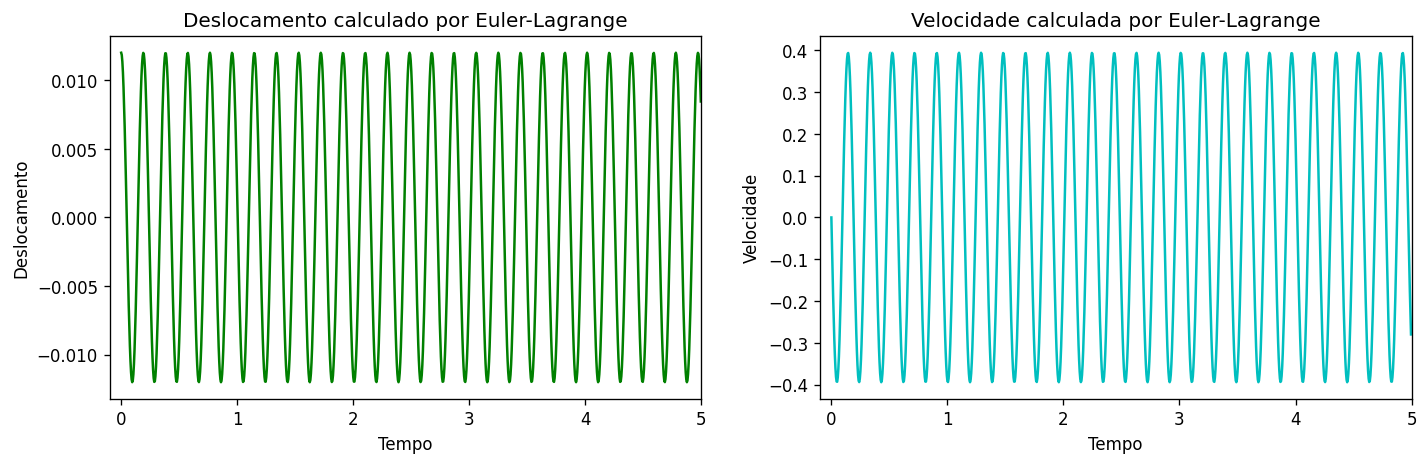

In [11]:
plt.figure(figsize=[14,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Deslocamento calculado pela 2ª lei de Newton")
plt.xlabel("Tempo") ; plt.ylabel("Deslocamento")
plt.plot(t, x_analytical[:, 0], 'g-', label=r'deslocamento') ; plt.xlim(-0.1, 5)
plt.subplot(1,2,2)
plt.title("Velocidade calculada pela 2ª lei de Newton")
plt.xlabel("Tempo") ; plt.ylabel("Velocidade")
plt.plot(t, x_analytical[:, 1], 'c-', label=r'velocidade') ; plt.xlim(-0.1, 5)
plt.savefig('cen1-new-h5.png')

plt.figure(figsize=[14,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Deslocamento calculado por Euler-Lagrange")
plt.xlabel("Tempo") ; plt.ylabel("Deslocamento")
plt.plot(t, x_autograd[:, 0], 'g-', label=r'deslocamento') ; plt.xlim(-0.1, 5)
plt.subplot(1,2,2)
plt.title("Velocidade calculada por Euler-Lagrange")
plt.xlabel("Tempo") ; plt.ylabel("Velocidade")
plt.plot(t, x_autograd[:, 1], 'c-', label=r'velocidade') ; plt.xlim(-0.1, 5)
plt.savefig('cen1-lag-h5.png')

## **Step 5: Generate training data**
Let's generate some training data by using the analytical method to sample mass-spring-damper dynamics.


In [12]:
time_step = 0.005
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

N = 10000
x0 = np.array([0.012, 0], dtype=np.float32)

# Train data
t = np.arange(start=0, stop=10, step=50/N, dtype=np.float32) # time steps 0 to N
%time x_train = jax.device_get(solve_analytical(x0, t)) # dynamics for first N time steps
%time xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) # time derivatives of each state
%time y_train = jax.device_get(analytical_step(x_train)) # analytical next step

# Test data
t_test = np.arange(start=10, stop=20, step=50/N, dtype=np.float32) # time steps N to 2N
%time x_test = jax.device_get(solve_analytical(x0, t_test)) # dynamics for next N time steps
%time xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) # time derivatives of each state
%time y_test = jax.device_get(analytical_step(x_test)) # analytical next step

CPU times: user 586 ms, sys: 5.66 ms, total: 591 ms
Wall time: 587 ms
CPU times: user 253 ms, sys: 183 ms, total: 436 ms
Wall time: 1.12 s
CPU times: user 215 ms, sys: 2.4 ms, total: 217 ms
Wall time: 415 ms
CPU times: user 2.83 ms, sys: 0 ns, total: 2.83 ms
Wall time: 2.84 ms
CPU times: user 12.4 ms, sys: 33 µs, total: 12.4 ms
Wall time: 26.9 ms
CPU times: user 1.24 ms, sys: 42 µs, total: 1.28 ms
Wall time: 1.3 ms


### Visualize train and test data

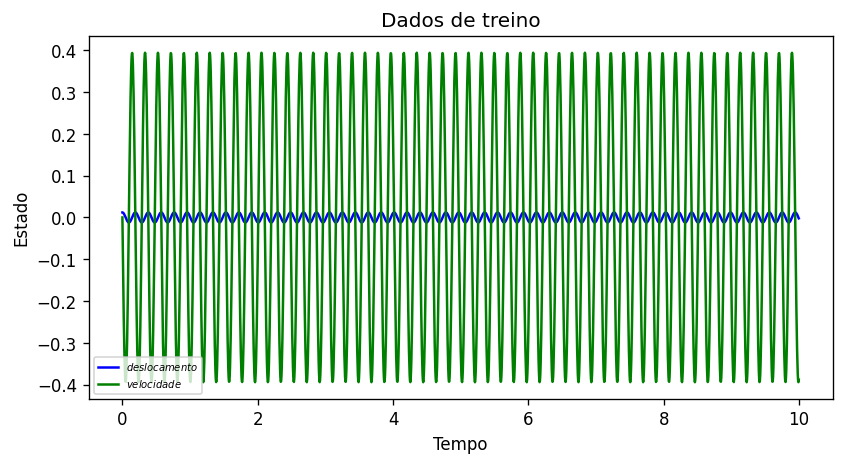

In [13]:
# preprocess
train_vis = jax.vmap(normalize_dp)(x_train)
test_vis = jax.vmap(normalize_dp)(x_test)

# plot train data
SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.plot(t, train_vis[:, 0], 'b-', label='$deslocamento$')
plt.plot(t, train_vis[:, 1], 'g-', label='$velocidade$')
plt.title("Dados de treino") ; plt.xlabel('Tempo') ; plt.ylabel('Estado')
plt.legend(fontsize=6)

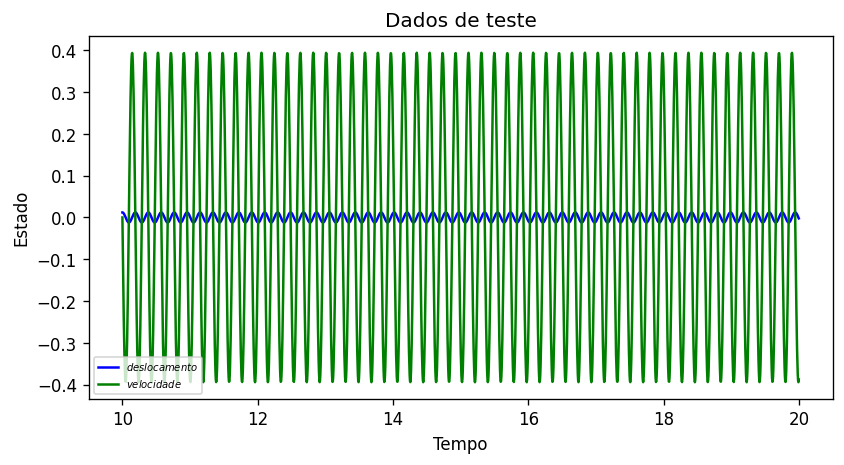

In [14]:
# plot test data
SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.plot(t_test, test_vis[:, 0], 'b-', label='$deslocamento$')
plt.plot(t_test, test_vis[:, 1], 'g-', label='$velocidade$')
plt.title("Dados de teste") ; plt.xlabel('Tempo') ; plt.ylabel('Estado')
plt.legend(fontsize=6)

## **Step 6: Build a Lagrangian Neural Network**
This section presents a bare-bones approach to approximating the Lagrangian with a neural network

### i) Build model and define the loss

In [15]:
# Replace the lagrangian with a parameteric model
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (1,)
    state = normalize_dp(jnp.concatenate([q, q_t]))

    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)

  return lagrangian

# Define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
    
  return jnp.mean((preds - targets) ** 2)

# Build a neural network model
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

### ii) Define optimization and data

In [16]:
@jax.jit
def update_timestep(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))

### iii) Train the model

In [17]:
%%time

rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 2))

# numbers in comments denote stephan's settings
batch_size = 100
test_every = 10
num_batches = 1500

train_losses = []
test_losses = []

# adam w learn rate decay
# Pesquisar funcionamento do retorno de optimizers.adam()
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))

opt_state = opt_init(init_params)

for iteration in range(batch_size * num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)

    train_loss = loss(params, (x_train, xt_train))
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))
    test_losses.append(test_loss)

    if iteration % (batch_size * test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")

  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params = get_params(opt_state)

iteration=0, train_loss=592.927368, test_loss=592.925964
iteration=1000, train_loss=41.993855, test_loss=41.993031
iteration=2000, train_loss=41.976646, test_loss=41.975822
iteration=3000, train_loss=41.939896, test_loss=41.939072
iteration=4000, train_loss=42.023136, test_loss=42.022312
iteration=5000, train_loss=41.987064, test_loss=41.986240
iteration=6000, train_loss=41.955479, test_loss=41.954659
iteration=7000, train_loss=42.025402, test_loss=42.024570
iteration=8000, train_loss=42.004597, test_loss=42.003769
iteration=9000, train_loss=41.962036, test_loss=41.961212
iteration=10000, train_loss=42.066597, test_loss=42.065773
iteration=11000, train_loss=42.015839, test_loss=42.015011
iteration=12000, train_loss=41.985580, test_loss=41.984760
iteration=13000, train_loss=41.488499, test_loss=41.487686
iteration=14000, train_loss=46.931652, test_loss=46.930824
iteration=15000, train_loss=42.608784, test_loss=42.607964
iteration=16000, train_loss=41.579884, test_loss=41.579063
iteratio

### iv) Plot losses over training

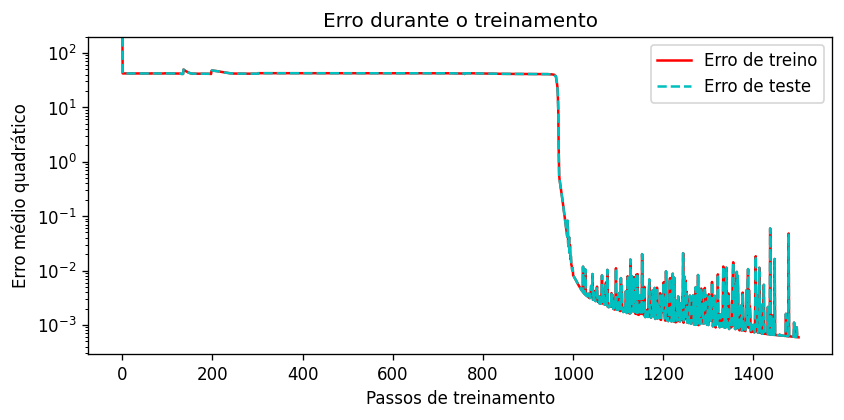

In [18]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses, 'r-', label='Erro de treino')
plt.plot(test_losses, 'c--', label='Erro de teste')
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Erro durante o treinamento')
plt.xlabel("Passos de treinamento") ; plt.ylabel("Erro médio quadrático")
plt.savefig('cen1-erro-h5.png')
plt.legend() ; plt.show()

## **Step 7: Make predictions with the model**

In [19]:
# choose an initial state
x1 = np.array([0.012, 0], dtype=np.float32)
N = 10000
t2 = np.arange(start=0, stop=5, step=50/N, dtype=np.float32)

%time x1_analytical = jax.device_get(solve_analytical(x1, t2))
%time x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=t2))

CPU times: user 1.74 ms, sys: 0 ns, total: 1.74 ms
Wall time: 3.75 ms
CPU times: user 4.03 s, sys: 47.1 ms, total: 4.08 s
Wall time: 4.38 s


(-0.1, 5.0)

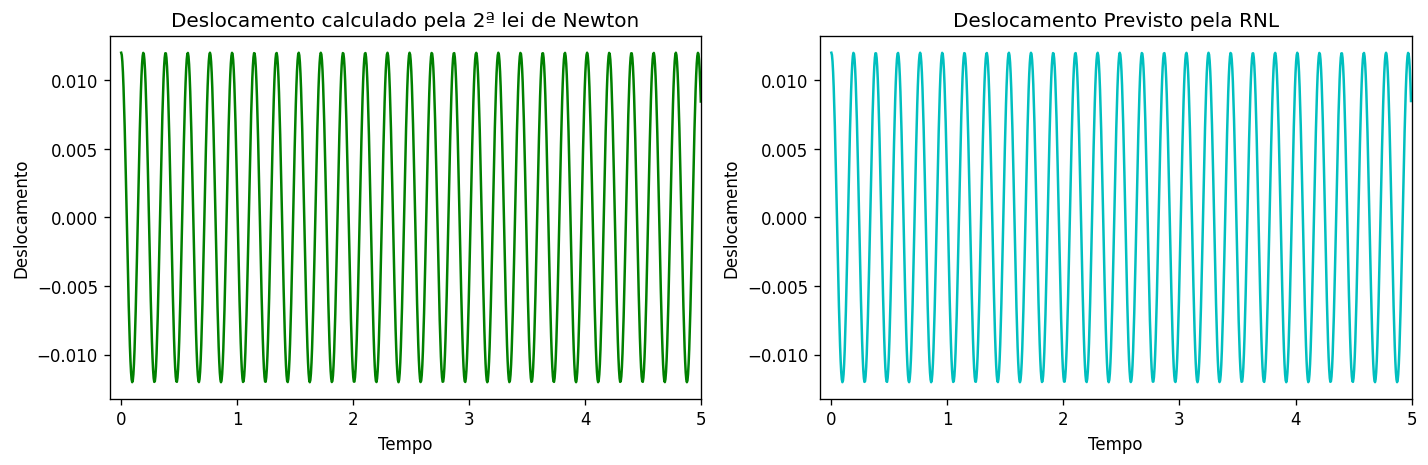

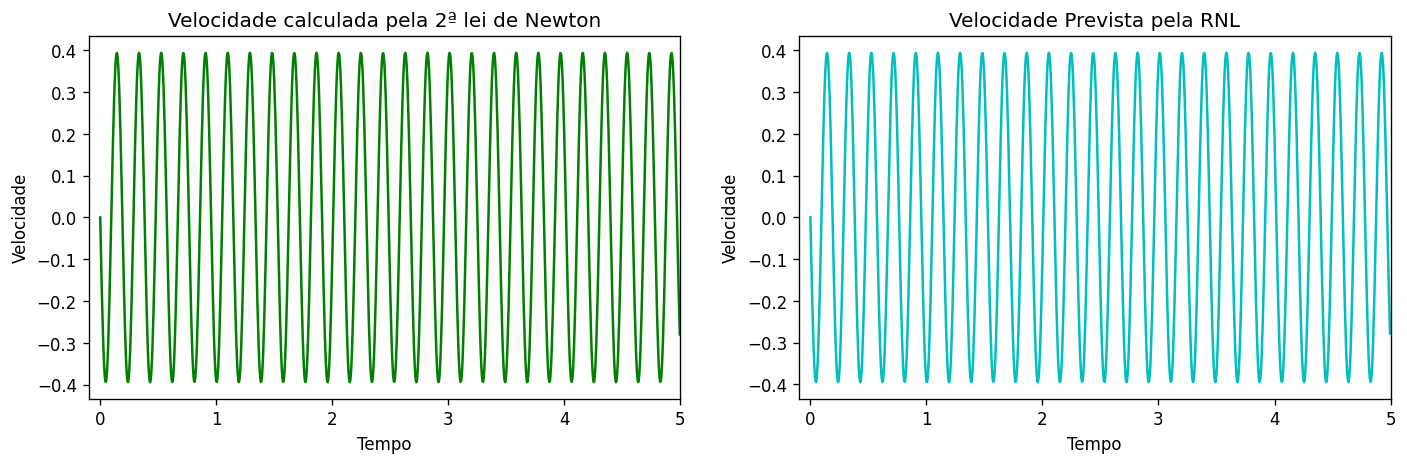

In [ ]:
plt.figure(figsize=[14,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Deslocamento calculado pela 2ª lei de Newton")
plt.xlabel("Tempo") ; plt.ylabel("Deslocamento")
plt.plot(t2, x1_analytical[:, 0], 'g-', label=r'deslocamento') ; plt.xlim(-0.1, 5)
plt.subplot(1,2,2)
plt.title("Deslocamento Previsto pela RNL")
plt.xlabel("Tempo") ; plt.ylabel("Deslocamento")
plt.plot(t2, x1_model[:, 0], 'c-', label=r'deslocamento') ; plt.xlim(-0.1, 5)

plt.figure(figsize=[14,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Velocidade calculada pela 2ª lei de Newton")
plt.xlabel("Tempo") ; plt.ylabel("Velocidade")
plt.plot(t2, x1_analytical[:, 1], 'g-', label=r'velocidade') ; plt.xlim(-0.1, 5)
plt.subplot(1,2,2)
plt.title("Velocidade Prevista pela RNL")
plt.xlabel("Tempo") ; plt.ylabel("Velocidade")
plt.plot(t2, x1_model[:, 1], 'c-', label=r'velocidade') ; plt.xlim(-0.1, 5)

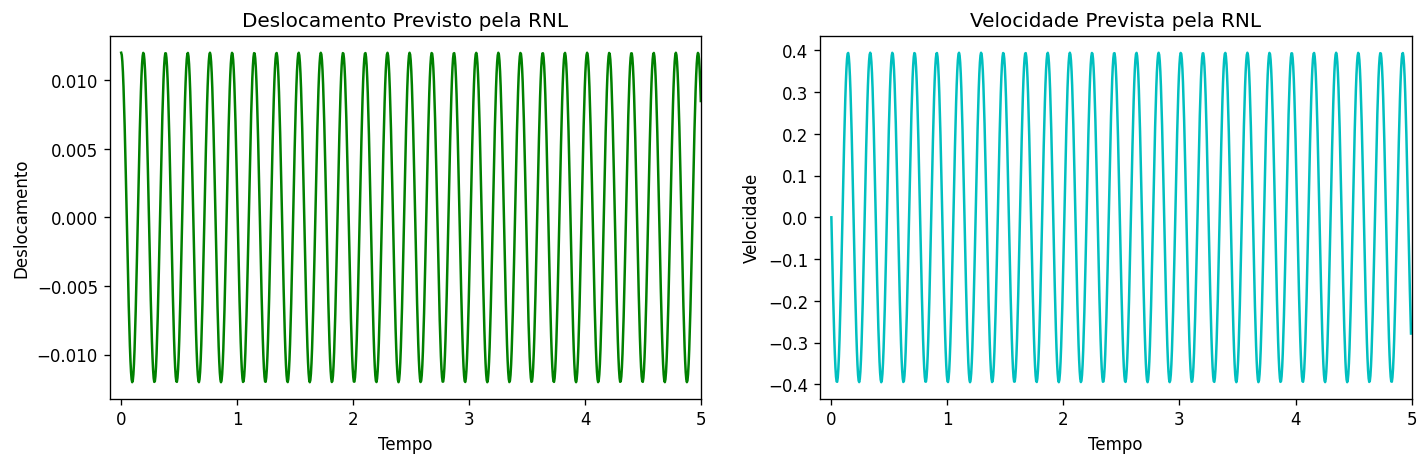

In [20]:
plt.figure(figsize=[14,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Deslocamento Previsto pela RNL")
plt.xlabel("Tempo") ; plt.ylabel("Deslocamento")
plt.plot(t2, x1_model[:, 0], 'g-', label=r'deslocamento') ; plt.xlim(-0.1, 5)
plt.subplot(1,2,2)
plt.title("Velocidade Prevista pela RNL")
plt.xlabel("Tempo") ; plt.ylabel("Velocidade")
plt.plot(t2, x1_model[:, 1], 'c-', label=r'velocidade') ; plt.xlim(-0.1, 5)
plt.savefig('cen1-rln-h5.png')

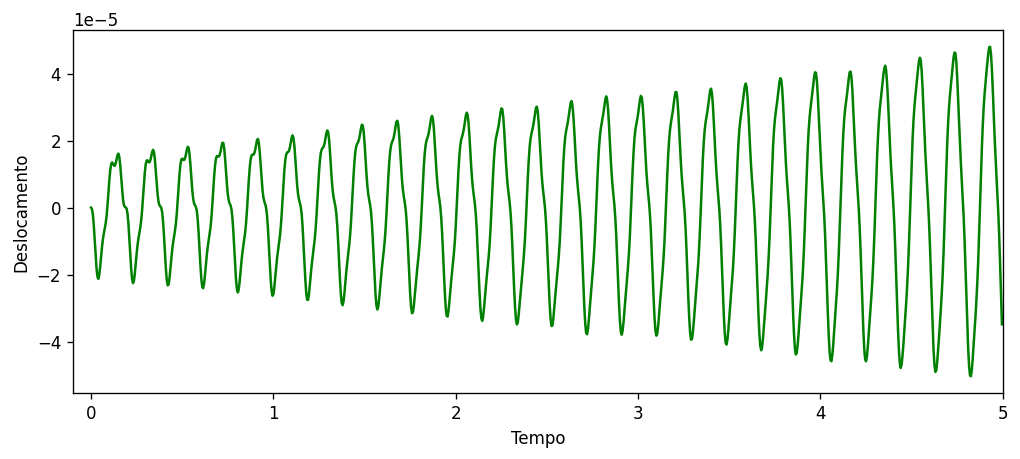

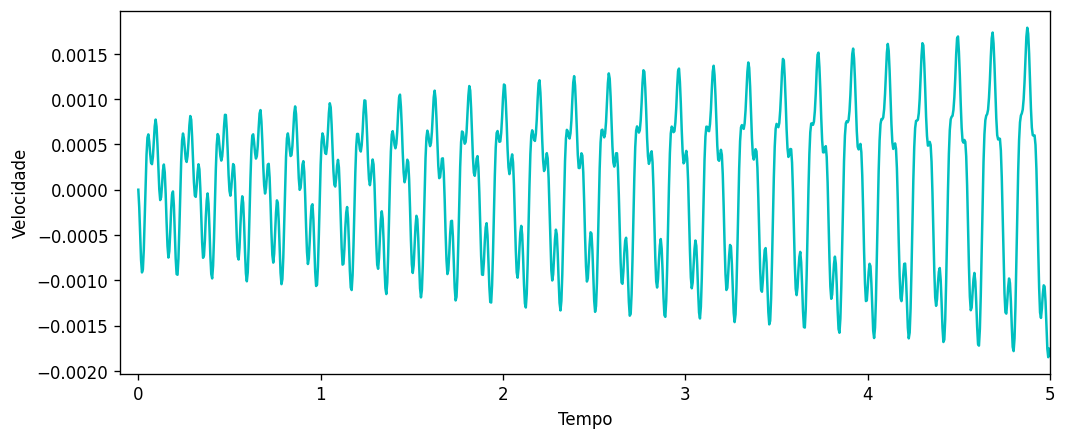

In [21]:
difference_of_states = x1_analytical - x1_model

plt.figure(figsize=[10,4], dpi=120)
# plt.title("Diferença entre o deslocamento calculado pela 2ª lei de Newton e o previsto pela RNL")
plt.xlabel("Tempo") ; plt.ylabel("Deslocamento")
plt.plot(t2, difference_of_states[:, 0], 'g-', label=r'deslocamento') ; plt.xlim(-0.1, 5)
plt.savefig('cen1-diff-desl-h5.png')

plt.figure(figsize=[10,4], dpi=120)
# plt.title("Diferença entre a velocidade calculada pela 2ª lei de Newton e a prevista pela RNL")
plt.xlabel("Tempo") ; plt.ylabel("Velocidade")
plt.plot(t2, difference_of_states[:, 1], 'c-', label=r'velocidade') ; plt.xlim(-0.1, 5)
plt.savefig('cen1-diff-vel-h5.png')